In [1]:
import os
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pycocotools.coco import COCO

Links for the dataset:
- Full challenge and explanation: [https://github.com/visipedia/inat_comp/tree/master/2017](https://github.com/visipedia/inat_comp/tree/master/2017)
- Train and Validation images (186 GB): [https://ml-inat-competition-datasets.s3.amazonaws.com/2017/train_val_images.tar.gz](https://ml-inat-competition-datasets.s3.amazonaws.com/2017/train_val_images.tar.gz)
- Training bounding box annotations (22 MB): [https://ml-inat-competition-datasets.s3.amazonaws.com/2017/train_2017_bboxes.zip](https://ml-inat-competition-datasets.s3.amazonaws.com/2017/train_2017_bboxes.zip)
- Validation bounding box annotations (3 MB): [https://ml-inat-competition-datasets.s3.amazonaws.com/2017/val_2017_bboxes.zip](https://ml-inat-competition-datasets.s3.amazonaws.com/2017/val_2017_bboxes.zip)

In [2]:
base_path = os.path.join('..', '..')
annotation_file = os.path.join(base_path, 'data', 'train_2017_bboxes.json')
coco_annotation = COCO(annotation_file)

loading annotations into memory...
Done (t=1.57s)
creating index...
index created!


In [10]:
# Category IDs
cat_ids = coco_annotation.getCatIds()
len(cat_ids), cat_ids[0], cat_ids[-1]

(5089, 1916, 4616)

The training set contains 5089 non-consecutive classes.

In [11]:
# Category names
cats = coco_annotation.loadCats(cat_ids)
cat_names = [cat["name"] for cat in cats]
cat_supercat = [cat['supercategory'] for cat in cats]
cat_names[:5], cat_supercat[:5]

(['Nicrophorus tomentosus',
  'Halyomorpha halys',
  'Betula lenta',
  'Hericium erinaceus',
  'Harpaphe haydeniana'],
 ['Insecta', 'Insecta', 'Plantae', 'Fungi', 'Animalia'])

Each category is an animal or plant species, with families of species as supercategories.

In [12]:
# Pick one image from a specific category (lumbricus terrestris)
img_ids = coco_annotation.getImgIds(catIds=[random.choice(cat_ids)])
rand_img_id = random.choice(img_ids)
rand_img_id

158235

In [13]:
# Image path and other metadata
img_info = coco_annotation.loadImgs([rand_img_id])[0]
img_file_name = img_info["file_name"]
print(img_info)

{'license': '3', 'file_name': 'train_val_images/Aves/Passerina leclancherii/469bcc253b3ef3517cf0901cb9367694.jpg', 'rights_holder': 'Marisela Ortega', 'height': 600, 'width': 800, 'id': 158235}


In [14]:
# Get all the annotations for the specified image.
ann_ids = coco_annotation.getAnnIds(imgIds=[rand_img_id], iscrowd=None)
anns = coco_annotation.loadAnns(ann_ids)
anns

[{'area': 31914.0,
  'iscrowd': 0,
  'image_id': 158235,
  'bbox': [253, 230, 394, 162],
  'category_id': 2171,
  'id': 112053}]

Note about annotations: 
- The `area` field of the annotations is an approximation (half of the area of the bbox), since segmentation masks were not collected.
- `iscrowd` is hard coded to 0 for all annotations, although it is possible that a box is around a crowd of instances (such as barnacles or mussels).
- For images with multiple box annotations there is no guarantee that all instances actually belong to the same category even though they are labeled as being the same category, although the boxed instances will belong to the same super category. Due to this problem, the validation set is restricted to images with single instances so that we can be confident the category label is correct for the given box.

In [15]:
# Distribution of annotations per class
distrib = {}
for cat in cat_ids:
    cat_img_ids = coco_annotation.getImgIds(catIds=[cat])
    if len(cat_img_ids) > 0:
        ann_ids = coco_annotation.getAnnIds(imgIds=cat_img_ids)
        distrib[cat] = len(ann_ids)
    else:
        distrib[cat] = 0

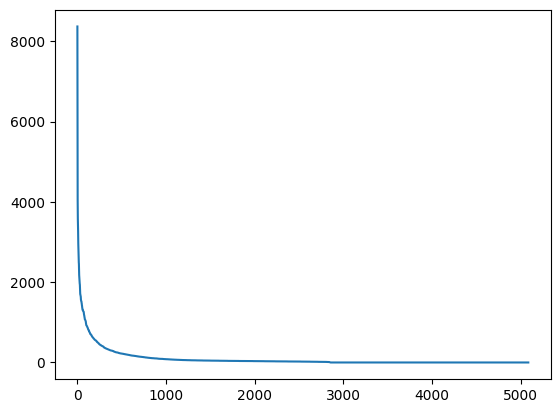

In [16]:
plt.plot(range(len(distrib)), sorted(distrib.values(), reverse=True))

In [17]:
max(distrib.values()), min(distrib.values()), np.mean(list(distrib.values()))

(8370, 0, 97.49734721949302)

On average, classes have 97.49 instances, with a maximum of 8370 and a minimum of 0.

In [18]:
distrib_df = pd.DataFrame.from_dict(distrib, orient='index', columns=['count']).sort_values(by='count', ascending=False)
len(distrib_df['count'][np.logical_and(distrib_df['count'] > 0, distrib_df['count'] < 100)]) / \
    len(distrib_df['count'][distrib_df['count'] > 0])

0.6850035038542397

Among the classes that have at least one instance, 68.5% have less than 100 instances.

In [19]:
len(distrib_df['count'][distrib_df['count'] == 0])

2235

There are 2235 classes (43.91%) with no annotations.

---

Validation distribution

In [20]:
val_annotation_file = os.path.join(base_path, 'data', 'val_2017_bboxes.json')
val_coco_annotation = COCO(val_annotation_file)
val_cat_ids = val_coco_annotation.getCatIds()
val_distrib = {}
for val_cat in val_cat_ids:
    val_cat_img_ids = val_coco_annotation.getImgIds(catIds=[val_cat])
    if len(val_cat_img_ids) > 0:
        val_ann_ids = val_coco_annotation.getAnnIds(imgIds=val_cat_img_ids)
        val_distrib[val_cat] = len(val_ann_ids)
    else:
        val_distrib[val_cat] = 0

loading annotations into memory...
Done (t=0.13s)
creating index...
index created!


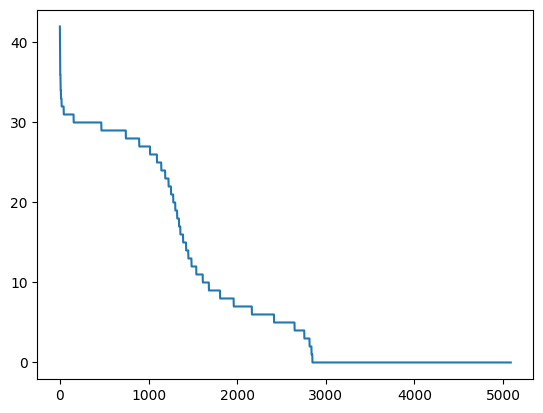

In [21]:
plt.plot(range(len(val_distrib)), sorted(val_distrib.values(), reverse=True))

In [22]:
max(val_distrib.values()), min(val_distrib.values()), np.mean(list(val_distrib.values()))

(42, 0, 9.576734132442523)

The validation distribution contains less images in general (9.576 on average)

In [23]:
val_distrib_df = pd.DataFrame.from_dict(val_distrib, orient='index', columns=['count']).sort_values(by='count', ascending=False)

In [24]:
len(np.array(val_distrib_df[val_distrib_df['count'] > 0].index))

2849

In [25]:
len(np.intersect1d(np.array(distrib_df[distrib_df['count'] > 0].index), np.array(val_distrib_df[val_distrib_df['count'] > 0].index)))

2849

The validation set has annoptations for 2849 classes, all coming from the same subset of classes that are also present in the training set.

In [26]:
len(np.union1d(np.array(distrib_df[distrib_df['count'] == 0].index), np.array(val_distrib_df[val_distrib_df['count'] > 0].index)))

5084

Indeed, the classes of the validation set are almost all different from those that are not present in the training set. Together they almost fill the 5089 classes of the dataset: which means that 5 classes are not even present in the validation set.

In [27]:
np.intersect1d(np.array(distrib_df[distrib_df['count'] > 0].index), np.array(val_distrib_df[val_distrib_df['count'] == 0].index))

array([ 513,  562, 1760, 3216, 4470])

Furthermore, the training set has 5 classes that are exclusive and are not present in the validation set.

## Dataset splitting

The dataset is definitely too large. Also, some of the classes have no associated bounding boxes. Therefore, we aim to re-shuffle the instances and explore the usable classes.

In [42]:
from tqdm import tqdm

annot_dict = {}
for k, ann in tqdm(val_coco_annotation.anns.items()):
    annot_dict[k] = {
        'from': 'val',
        'cat_id': ann['category_id'],
        'cat_name': val_coco_annotation.loadCats([ann['category_id']])[0]['name'],
        'supercat': val_coco_annotation.loadCats([ann['category_id']])[0]['supercategory'],
        'image_filename': val_coco_annotation.loadImgs([ann['image_id']])[0]['file_name'],
        'has_bbox': 'bbox' in ann
    }

for k, ann in tqdm(coco_annotation.anns.items()):
    annot_dict[k] = {
        'from': 'train',
        'cat_id': ann['category_id'],
        'cat_name': coco_annotation.loadCats([ann['category_id']])[0]['name'],
        'supercat': coco_annotation.loadCats([ann['category_id']])[0]['supercategory'],
        'image_filename': coco_annotation.loadImgs([ann['image_id']])[0]['file_name'],
        'has_bbox': 'bbox' in ann
    }

  0%|          | 0/48736 [00:00<?, ?it/s]

100%|██████████| 496164/496164 [00:00<00:00, 505297.86it/s]


In [43]:
annot_pd = pd.DataFrame.from_dict(annot_dict).T

In [44]:
annot_pd

,from,cat_id,cat_name,supercat,image_filename,has_bbox
0,val,0,Marmota flaviventris,Mammalia,train_val_images/Mammalia/Marmota flaviventris...,True
11,val,0,Marmota flaviventris,Mammalia,train_val_images/Mammalia/Marmota flaviventris...,True
18,val,0,Marmota flaviventris,Mammalia,train_val_images/Mammalia/Marmota flaviventris...,True
21,val,0,Marmota flaviventris,Mammalia,train_val_images/Mammalia/Marmota flaviventris...,True
37,val,0,Marmota flaviventris,Mammalia,train_val_images/Mammalia/Marmota flaviventris...,True
...,...,...,...,...,...,...
538592,train,5088,Piranga bidentata,Aves,train_val_images/Aves/Piranga bidentata/a84685...,True
538593,train,5088,Piranga bidentata,Aves,train_val_images/Aves/Piranga bidentata/3bd614...,True
538594,train,5088,Piranga bidentata,Aves,train_val_images/Aves/Piranga bidentata/25b7cc...,True
538595,train,5088,Piranga bidentata,Aves,train_val_images/Aves/Piranga bidentata/75d9dd...,True


In [53]:
print(f'Number of classes with bboxes: {len(annot_pd[annot_pd["has_bbox"] == True]["cat_id"].unique())}')
print(f'Total annotations: {len(annot_pd)}, with bbox: {len(annot_pd[annot_pd["has_bbox"] == True])}')
print(f"Total supercategories: {len(annot_pd['supercat'].unique())}")

Number of classes with bboxes: 2854
Total annotations: 544900, with bbox: 544900
Total supercategories: 9


In [59]:
supercat_distr = {}
for supercat in annot_pd['supercat'].unique():
    supercat_pd = annot_pd[annot_pd['supercat'] == supercat]
    supercat_distr[supercat] = dict(supercat_pd['cat_name'].value_counts())

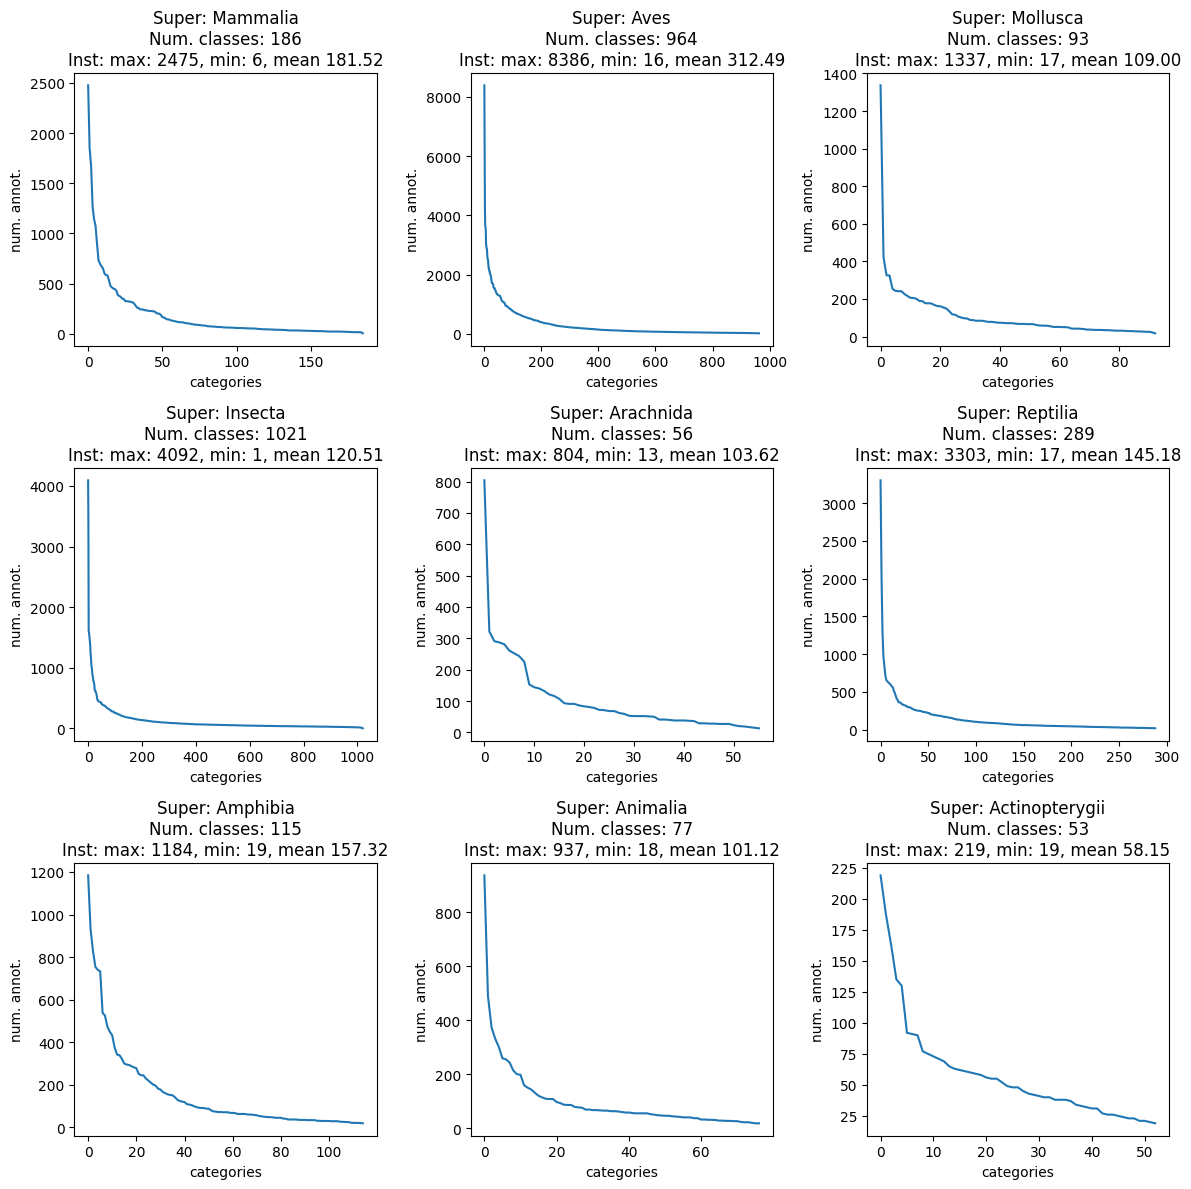

In [84]:
fig, axs = plt.subplots(3, 3, figsize=(12,12))
for i in range(3):
    for j in range(3):
        category = list(supercat_distr.keys())[i*3+j]
        axs[i][j].plot(range(len(supercat_distr[category])), sorted(supercat_distr[category].values(), reverse=True))
        axs[i][j].set_title(f"Super: {category}\nNum. classes: {len(supercat_distr[category])}\n"
                            f"Inst: max: {max(supercat_distr[category].values())}, min: {min(supercat_distr[category].values())}, "
                            f"mean {np.mean(list(supercat_distr[category].values())):.2f}")
        axs[i][j].set_xlabel('categories')
        axs[i][j].set_ylabel('num. annot.')
fig.tight_layout()

In [97]:
annot_per_class = {}
for cat in tqdm(annot_pd['cat_id'].unique()):
    annot_per_class[cat] = sum(annot_pd['cat_id'] == cat)

100%|██████████| 2854/2854 [03:11<00:00, 14.89it/s]


In [113]:
THRESHOLDS = 65
novel_set = []
base_set = []
novel_set_images = 0
base_set_images = 0
for cat, items in annot_per_class.items():
    if items > THRESHOLDS:
        base_set.append((cat, items))
    else:
        novel_set.append((cat, items))
for n in tqdm(novel_set):
    novel_set_images += len(annot_pd[annot_pd['cat_id'] == n[0]]['image_filename'].unique())
for b in tqdm(base_set):
    base_set_images += len(annot_pd[annot_pd['cat_id'] == b[0]]['image_filename'].unique())
base_set_itemcount = sum(v[1] for v in base_set)
novel_set_itemcount = sum(v[1] for v in novel_set)
print(f"Using class instances threshold {THRESHOLDS}\n"
      f"Base set contains {base_set_itemcount} ({base_set_itemcount*100/(base_set_itemcount+novel_set_itemcount):.2f}%) annotations from {len(base_set)} categories spanning {base_set_images} different images.\n"
      f"Novel set contains {novel_set_itemcount} ({novel_set_itemcount*100/(base_set_itemcount+novel_set_itemcount):.2f}%) annotations from {len(novel_set)} categories spanning {novel_set_images} different images.")

100%|██████████| 1464/1464 [01:02<00:00, 23.58it/s]

Using class instances threshold 65
Base set contains 490412 (90.00%) annotations from 1464 categories spanning 395023 different images.
Novel set contains 54488 (10.00%) annotations from 1390 categories spanning 49296 different images.
